# Mumford Stats practice

## Video 2: Two stage random effects formaulation

Standard simple regression

$RT = \beta_0 + \beta_1 Days + \epsilon$

or another way of writing it is:

$\begin{bmatrix}265\\252\\451\\335\end{bmatrix} = \begin{bmatrix}1&0\\1&1\\1&2\\1&3\end{bmatrix} \begin{bmatrix}\beta_0\\\beta_1\end{bmatrix} + \begin{bmatrix}\epsilon_1\\\epsilon_2\\\epsilon_3\\\epsilon_4\end{bmatrix}$

which can be more compatx like this
$Y = \mathcal{Z}\beta + \epsilon, \epsilon \sim N(0, \sigma^2 I_n)$

where $\mathcal{Z}$ is the design matrix:

$\mathcal{Z}=\begin{bmatrix}1&0\\1&1\\1&2\\1&3\end{bmatrix}$


In the two stage model were estimate each subject's slope and intercept separately:

$Y_i = \mathcal{Z_i}\beta_i + \epsilon_i, \epsilon_i \sim N(0, \sigma^2 I_{n_i})$

we are assuming $\sigma$ is the same for each subject.  Some other packages can do this.

The second stage model is

$\beta_i = \mathcal{A_i}\beta + b_i, b_i \sim N(0, G)$

$b_i$ is the amount of noise between subjects in the slopes and intercept.  It is expressed with a covariance term $G$ because they might be correlated (slope and intercept).   You don't actually estimate the $b_i$ values you estimate the $G$.

$\mathcal{A_i}$ is the identity matrix usually.

If you plug second stage into first stage:

$Y_i = \mathcal{Z_i}\mathcal{A_i}\beta + \mathcal{Z_i}b_i+\epsilon_i, \epsilon_i \sim N(0, \sigma^2 I_{n_i}), b_i \sim N(0, G)$

The $\beta$ is the "fixed effect" usually what we are interested in assessing.

The $\b_i$ is the random effect variable of between subject variance

The $epsilon_i$ is the within subject variance.



In [1]:
# Load necessary libraries

# data stuff
import pandas as pd
import numpy as np
import numpy.random as npr

# stats stuff
import scipy.stats.stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

# for py2r stuff
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['R_HOME'] = '/usr/local/bin/R'
import pymer4.models as pymer
# plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns

# bayesian stuff
import arviz as az
import bambi as bmb
import pymc3 as pm

# fun stuff
from rich import print, pretty, inspect
from rich.progress import track

In [76]:
def makeFakeSleepStudyData(subj_num, days, sigma):
    subj_col = np.full((days,),subj_num)
    day_col = np.arange(0,days)
    intercept, slope = npr.multivariate_normal([251,10], [[24**2,0],[0,10**2]])
    rt = intercept + slope*day_col + npr.normal(loc=0, scale=sigma, size=days)
    return pd.DataFrame({'subj':subj_col, 'day':day_col, 'rt': rt})

nsubj=16
sigma = 30
days = 10

df = pd.concat([makeFakeSleepStudyData(subj_num,days, sigma) for subj_num in range(nsubj)])

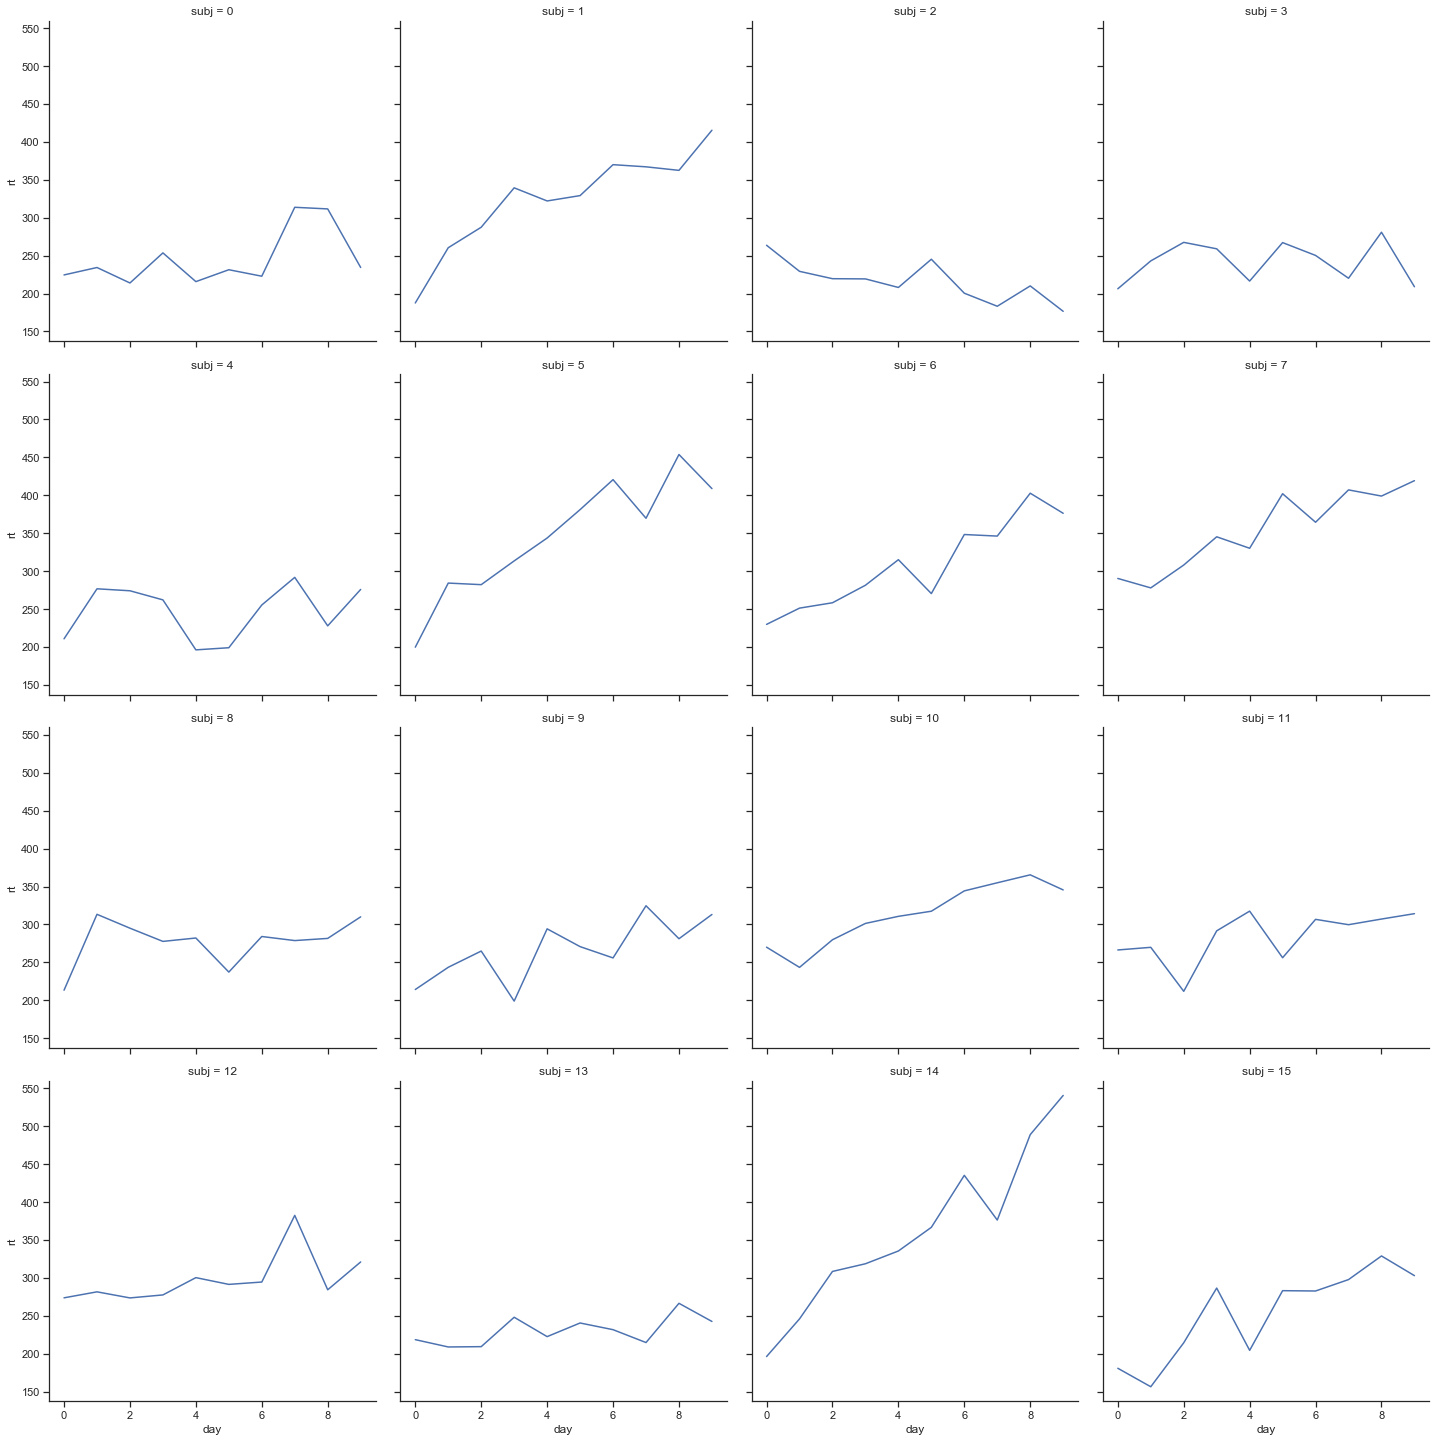

In [77]:
sns.relplot(x='day', y='rt', col='subj', col_wrap=4, kind='line', data=df)

In [93]:
md=sm.MixedLM.from_formula("rt ~ day", df, groups=df['subj'])
mdf= md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: rt       
No. Observations:  160     Method:             REML     
No. Groups:        16      Scale:              1558.4238
Min. group size:   10      Log-Likelihood:     -830.5617
Max. group size:   10      Converged:          Yes      
Mean group size:   10.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  237.147   12.435 19.071 0.000 212.775 261.519
day         10.725    1.087  9.871 0.000   8.596  12.855
Group Var 1935.720   20.335                             



In [37]:
model=pymer.Lmer('rt ~ day + (1+day|subj)', data=df)
print(model.fit(REML=True))

Formula: rt~day+(1+day|subj)

Family: gaussian	 Inference: parametric

Number of observations: 160	 Groups: {'subj': 16.0}

Log-likelihood: -806.002 	 AIC: 1612.004

Random effects:

                 Name      Var     Std
subj      (Intercept)  602.805  24.552
subj              day  148.610  12.191
Residual               929.974  30.495

              IV1  IV2   Corr
subj  (Intercept)  day -0.362

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)   236.447  221.552  251.342  7.600  15.0  31.113  0.000  ***
day            12.753    6.557   18.948  3.161  15.0   4.034  0.001   **


In [38]:
model=pymer.Lmer('rt ~ day + (day|subj)', data=df)
print(model.fit(REML=True))

Formula: rt~day+(day|subj)

Family: gaussian	 Inference: parametric

Number of observations: 160	 Groups: {'subj': 16.0}

Log-likelihood: -806.002 	 AIC: 1612.004

Random effects:

                 Name      Var     Std
subj      (Intercept)  602.805  24.552
subj              day  148.610  12.191
Residual               929.974  30.495

              IV1  IV2   Corr
subj  (Intercept)  day -0.362

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)   236.447  221.552  251.342  7.600  15.0  31.113  0.000  ***
day            12.753    6.557   18.948  3.161  15.0   4.034  0.001   **


In [41]:
model.fixef

,(Intercept),day
0,239.488909,8.728109
1,246.447224,13.253108
2,262.839296,6.840064
3,220.598601,20.848688
4,228.604242,-7.779330
5,246.984783,3.143458
6,266.748099,3.848168
7,219.382655,10.854378
8,246.313350,12.447120
9,234.900175,14.817895


In [35]:
res.BIC

AttributeError: 'DataFrame' object has no attribute 'BIC'

## t-test equivalent

In [71]:
group1mean, group2mean = 10, 20
groupstd = 2.
subj_col = range(30)
data = np.concatenate((npr.normal(loc=group1mean, scale=groupstd, size=15),npr.normal(loc=group2mean, scale=groupstd, size=15)))
cond = [1]*15+[2]*15
df=pd.DataFrame({'subj': subj_col, 'cond': cond, 'dv': data})

In [56]:
df.head()

,subj,cond,dv
0,0,1,9.019312
1,1,1,7.906432
2,2,1,11.817954
3,3,1,8.498817
4,4,1,13.186811


In [72]:
pd.get_dummies(df.cond)

,1,2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [70]:
model=pymer.Lm('dv ~ 1+cond', data=df)
print(model.fit(REML=True))

Formula: dv~1+cond

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 30	 R^2: 0.924	 R^2_adj: 0.921

Log-likelihood: -60.109 	 AIC: 124.219	 BIC: 127.021

Fixed effects:

           Estimate  2.5_ci  97.5_ci     SE  DF  T-stat  P-val  Sig
Intercept     8.612   7.630    9.594  0.480  28  17.957    0.0  ***
cond         12.520  11.131   13.909  0.678  28  18.459    0.0  ***


In [68]:
import pingouin as pg

pg.ttest(df[df['cond']==0]['dv'],df[df['cond']==1]['dv'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-18.459,28,two-sided,3.284804e-17,"[-13.91, -11.13]",6.74,8.033e+13,1.0
